In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

import json
from pymongo import MongoClient
from bson.objectid import ObjectId

import pickle

In [75]:
# Import cleaned listing data

client = MongoClient()
db = client.property_investor
listings = db.listings
cursor = listings.find({'state': 'MN'})
df = pd.DataFrame(list(cursor))

print(df.shape)
df.head()

(90, 31)


,_id,address,annual_income,baths,beds,city,cluster,cost_square_feet,days_on_market,description_text,...,square_feet,state,unit_1_beds,unit_2_beds,unit_3_beds,unit_4_beds,unit_rent,url,year_built,zip
0,58b5f1b0dcc9d8d448be2325,3039 Bryant Ave S,85440.0,1.0,4.0,Minneapolis,1.0,174.0,1.0,Great investment opportunity in the heart of U...,...,2952.0,MN,1.0,1.0,1.0,1.0,775.0,http://www.redfin.com/MN/Minneapolis/3039-Brya...,1913.0,55408
1,58b5f1b0dcc9d8d448be2326,3307 29th Ave S,19704.0,2.0,3.0,Minneapolis,2.0,123.0,1.0,"New windows, siding, foundation, updated bathr...",...,1695.0,MN,2.0,1.0,NaN,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3307-29th...,1900.0,55406
2,58b5f1b0dcc9d8d448be2328,3540 Bloomington Ave,74112.0,1.0,8.0,Minneapolis,0.0,59.0,3.0,"great investment property , great location. Cu...",...,4992.0,MN,2.0,2.0,2.0,2.0,NaN,http://www.redfin.com/MN/Minneapolis/3540-Bloo...,1928.0,55407
3,58b5f1b0dcc9d8d448be2329,3028 Fillmore St NE,60480.0,3.0,5.0,Minneapolis,1.0,125.0,3.0,Beautiful Audobon Park duplex that is owner oc...,...,3394.0,MN,3.0,2.0,1.0,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3028-Fill...,1935.0,55418
4,58b5f1b0dcc9d8d448be232a,3945 Van Nest Ave,49536.0,1.0,3.0,Minneapolis,1.0,120.0,3.0,This classic Minneapolis duplex is filled with...,...,2289.0,MN,1.0,1.0,1.0,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3945-Van-...,1891.0,55409


In [81]:
df.head()

,_id,address,annual_income,baths,beds,city,cluster,cost_square_feet,days_on_market,description_text,...,unit_1_beds,unit_2_beds,unit_3_beds,unit_4_beds,unit_rent,url,year_built,zip,income_ratio,monthly_income
0,58b5f1b0dcc9d8d448be2325,3039 Bryant Ave S,85440.0,1.0,4.0,Minneapolis,1.0,174.0,1.0,Great investment opportunity in the heart of U...,...,1.0,1.0,1.0,1.0,775.0,http://www.redfin.com/MN/Minneapolis/3039-Brya...,63.0,55408,0.165935,7120.0
1,58b5f1b0dcc9d8d448be2326,3307 29th Ave S,19704.0,2.0,3.0,Minneapolis,2.0,123.0,1.0,"New windows, siding, foundation, updated bathr...",...,2.0,1.0,NaN,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3307-29th...,50.0,55406,0.094278,1642.0
2,58b5f1b0dcc9d8d448be2328,3540 Bloomington Ave,74112.0,1.0,8.0,Minneapolis,0.0,59.0,3.0,"great investment property , great location. Cu...",...,2.0,2.0,2.0,2.0,NaN,http://www.redfin.com/MN/Minneapolis/3540-Bloo...,78.0,55407,0.251227,6176.0
3,58b5f1b0dcc9d8d448be2329,3028 Fillmore St NE,60480.0,3.0,5.0,Minneapolis,1.0,125.0,3.0,Beautiful Audobon Park duplex that is owner oc...,...,3.0,2.0,1.0,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3028-Fill...,85.0,55418,0.142306,5040.0
4,58b5f1b0dcc9d8d448be232a,3945 Van Nest Ave,49536.0,1.0,3.0,Minneapolis,1.0,120.0,3.0,This classic Minneapolis duplex is filled with...,...,1.0,1.0,1.0,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3945-Van-...,41.0,55409,0.180131,4128.0


In [22]:
df.columns

Index(['_id', 'address', 'annual_income', 'baths', 'beds', 'city', 'cluster',
       'cost_square_feet', 'days_on_market', 'description_text',
       'hoa_per_month', 'latitude', 'location', 'longitude', 'lot_size',
       'mls_num', 'num_units', 'price', 'property_type', 'rent_index',
       'source', 'square_feet', 'state', 'unit_1_beds', 'unit_2_beds',
       'unit_3_beds', 'unit_4_beds', 'unit_rent', 'url', 'year_built', 'zip',
       'income_ratio'],
      dtype='object')

In [66]:
# features to be used in model
subset = ['rent_index', 'latitude', 'longitude']

In [67]:
cluster_df = df[subset].copy(deep=True)
cluster_df = cluster_df.dropna()

In [68]:
cluster_df = cluster_df.copy(deep=True)
cluster_df.head()

,rent_index,latitude,longitude
0,1.293498,44.947055,-93.290403
1,0.492879,44.942919,-93.229680
2,0.814861,44.938034,-93.252809
3,0.850774,45.023095,-93.242533
4,1.000000,44.930985,-93.278601


In [83]:
# Scale data
scale = StandardScaler()
scale.fit(cluster_df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [84]:
# Get inertia and silouette scores for 2-10 clusters
Inertia = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(cluster_df)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(cluster_df, labels, metric='euclidean'))
    Inertia.append(km.inertia_)

In [85]:
Sil_coefs

[0.32459655379891744,
 0.39710657305849878,
 0.42322443654045339,
 0.43344732094779936,
 0.46995972392322877,
 0.45892216601527791,
 0.48282594677612878,
 0.56335985419604562]

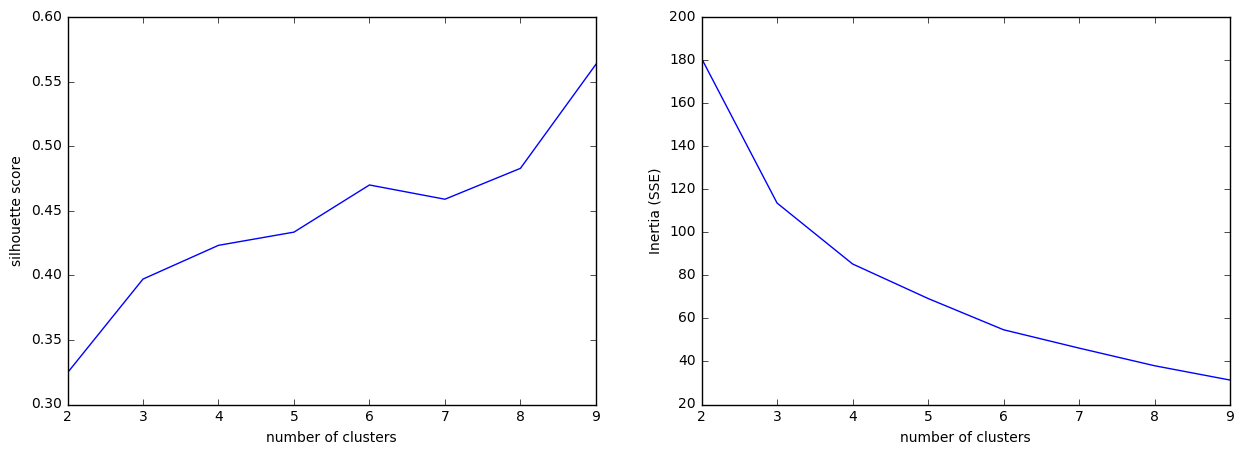

In [86]:
# Plot silhouette scores and inertia
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette score')

# plot here on ax2
ax2.plot(k_clusters, Inertia)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('Inertia (SSE)');

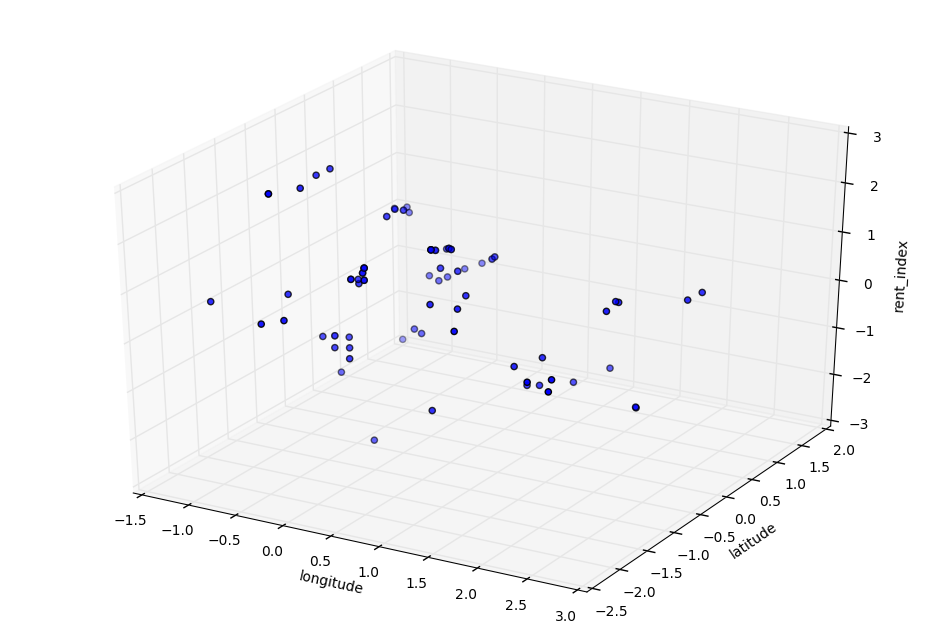

In [87]:
# Plot 3D data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# subset = 'rent_index', 'latitude', 'latitude'

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')

xs = cluster_df['longitude']
ys = cluster_df['latitude']
zs = cluster_df['rent_index']
ax.scatter(xs, ys, zs)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('rent_index')

plt.show()

In [57]:
km = KMeans(n_clusters=6, random_state=1)
km.fit(df[['beds', 'num_units', 'year_built']])
km.cluster_centers_

array([[   5.25      ,    2.75      ,   82.        ],
       [   5.29787234,    2.14893617,   50.93617021],
       [   5.44444444,    2.88888889,  119.77777778],
       [   3.88888889,    2.11111111,   40.55555556],
       [   6.        ,    4.        ,  156.        ],
       [   6.        ,    2.75      ,   63.9375    ]])

In [ ]:
# Conclusion: There does not appear to be any noteworthy structure to this data. 